Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as any collaborators you worked with:

In [1]:
COLLABORATORS = "Nicolette Auld-Griffith, Kate McGrath, Reuben Solnick"

---

In [2]:
from __future__ import print_function
%matplotlib inline
%precision 16
import numpy
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from stability_diagrams import plot_stability_ssms
from stability_diagrams import plot_stability_lmm

# HW 5:  ODE Methods - Initial Value Problems

These questions will use a mixture of scipy routines and hand-rolled ODE solver methods (which you can use from the notes)

## Question 1 - The SIR model for Infectious diseases

ODE based models are a classical approach to understanding the spread of infectious diseases.

One of the pioneering models is the SIR model of [Kermack and McKendrick, (1927)](https://royalsocietypublishing.org/doi/10.1098/rspa.1927.0118) which is a mean-field theory for large populations that assumes the general population can be divided into three subgroups

* $S$: the number of susceptible patients
* $I$: the number of infected patients
* $R$: the number of recovered (or otherwise) patients

Given these definitions, the simplest dynamical systems for the three populations can be written

$$
\begin{aligned}
\frac{d S}{dt} &= -\alpha SI \\
\frac{d I}{dt} &= \alpha SI -\beta I\\
\frac{d R}{dt} &= \beta I \\
\end{aligned}
$$

where $\alpha$ is the infection rate per person, and $\beta$ is the recovery rate (hint: check the units) 

This is the original Kermack and McKendrick model.  We will discuss a host of themes and variations later.  If you are interested [Siettos and Russo, (2013)](https://doi.org/10.4161/viru.24041) provides a short overview of the much larger field of epidemiology modeling (although this paper has some significant mistakes with respect to the analysis of the Kermack and McKendrick model, and I'm sure there are considerably more papers on modeling epidemics now).

We will explore this problem through a combination of Analysis and Numerical methods and to use it to test different methods for ODE solvers.


**(a)** [4] First try to explain in words,  what this system of ODE's describes

The ODEs above describe an exponential rise and decay of infected patients (3 ways to describe the change of the population of infected people- the overall population of people stays constant though). It can also predict this change in the future. This only has 3 variables so it is a very basic model infection. 

### Some analysis.  

Here we will conduct some elementary dimensional analysis to reduce the parameter space.  More detailed analysis of this system can be found  in Steve Strogatz' excellent text on [dynamical systems](https://smile.amazon.com/Nonlinear-Dynamics-Chaos-Applications-Nonlinearity/dp/0813349109/ref=dp_ob_image_bk)

**(b)** [2] Show that the SIR equations imply that   $S + I + R = N$  where $N$ is a constant (the total population of susceptible people that can all interact)

Can integrate to find equations for $S$, $I$, and $R$.

$$ 
\begin{aligned}
S &= - \alpha SIt + C_S \\
I &= \alpha SIt - \beta It + C_I \\
R &= \beta It + C_R \\
\end{aligned}
$$

With each C being some constant. From here, we can simply to a single function with constant N:

$$
\begin{aligned}
I &= C_S - S - (R - C_R) + C_I \\
S + I + R &= C_S + C_I + C_R \\
S + I + R &= N \\
\end{aligned}
$$

**(c)**  [4] Show that under  the change of variables (linear scaling of the variables)

$$
\begin{matrix}
    S = N s, & I = Ni, & R = Nr, & t = \tau\frac{1}{\alpha N} \\
\end{matrix}
$$

The original equations can be rewritten as the scaled equations 

$$
\begin{align}
    \frac{d s}{d\tau} &= -si\\
    \frac{d i}{d\tau} &= (s - s^*)i  \\
    \frac{d r}{d\tau} & = s^* i \\
\end{align}
$$

where 
$$
    s^* = \frac{\beta}{\alpha N}
$$



**Notes**,  
* if we write $s = S/N$ etc. then $s$ is simply the fraction of the total population that is susceptible.  
* Also show that $s + i + r = 1$.
* this scaling reduces a two-parameter problem to a one parameter problem where the only variable is $s^*$



We can show $s + i + r = 1$ by using S + I + R = N:

$$
\begin{aligned}
s + i + r &= S/N + I/N + R/N \\
s + i + r &= \frac{S + I + R}{N} \\
s + i + r &= N/N \\
s + i + r &= 1 \\
\end{aligned}
$$

And use the original system and the new variables:

$$ 
\begin{aligned}
s &= - (\alpha Ns Ni \tau\frac{1}{\alpha N} + C_S) / N \\
  &= - si \tau + C_{S1} \\
i &= (\alpha Ns Ni \tau\frac{1}{\alpha N} - \beta Ni \tau\frac{1}{\alpha N} + C_I) / N \\
  &= si \tau - \frac{\beta i \tau}{\alpha N} + C_{I1} \\
r &= (\beta Ni \tau\frac{1}{\alpha N} + C_R) / N \\
  &= \frac{\beta i \tau}{\alpha N} + C_{R1} \\
\end{aligned}
$$

Can then find the derivatives to write the scaled equations, and $s^*$:

$$ 
\begin{aligned}
\frac{d s}{d\tau} &= - si \\
\frac{d i}{d\tau} &= si - \frac{\beta i}{\alpha N} = (s - s^*) i \\
\frac{d r}{d\tau} &= \frac{\beta i}{\alpha N} = s^* i \\
\end{aligned}
$$

**(d)**  [2] Given that $s^*$ is a constant that only depends on the infection rate per capita $\alpha$, the recovery rate $\beta$ and the total population $N$,  interpret the equation for the change in the number of infections

$$
    \frac{d i}{d\tau} = (s - s^*) i
$$
as a function of the susceptible fraction of the population $s$.

The change of number of infections in relation to the susceptible population is equal to the fraction of infected patients times the difference of the fraction of susceptible people in population and the rate of people that get infected divided by the rate that recover. If our difference is positive then we have more recovered than infections. S star is the proportion of infection rate over recovery rate, meaning that a smaller s star is ideal from a public health standpoint. 

### Numerical Methods

we will now explore the behavior of this model numerically using a range of our basic algorithms by solving the scaled dynamical system

$$
    \frac{d\mathbf{u}}{dt} = \mathbf{F}(t,\mathbf{u}, s^*),\quad\mathbf{u}(0)=\mathbf{u}_0
$$

where 
$$
    \mathbf{u} = \begin{bmatrix} s \\ i \\ r \\ \end{bmatrix}, \quad 
    \mathbf{F}(t,\mathbf{u},s^*) = \begin{bmatrix} -si \\ (s - s^*)i \\ s^*i \\ \end{bmatrix}
$$

**(e)** [4] Write function to return the RHS of the scaled dynamical system $\mathbf{F}(t,\mathbf{u},s^*)$ as a numpy array

In [16]:
def F(t, u, s_star):
    """ RHS of scaled SIR model of Kermack and McKendrick
    
    parameters
    ----------
        t: float
            time (just a dummy variable here because this is an autonomous system)
        u: numpy array
            array of scaled [ s, i, r ] values such that sum(u) = 1 
            (and s,i, r are fractions of the total population N)
        s_star: float
            scaled critical susceptible population = \beta/(\alpha N)
            
    returns:
        F(u): numpy array
    """
    s = u[0] 
    i = u[1]
    r = u[2]
    
    F = numpy.array([-s * i,
                    (s - s_star)* i,
                    s_star*i])
    
    return F 
    
                     
    

In [17]:
# Let's assume the critical level of immunity is 60% of the total population
s_star = 0.6

# let there initially be .01 % infected cases and no recovered
t = 0.
i_0 = 1.e-4
u_0 = numpy.array([1. - i_0, i_0, 0.0])
answer = numpy.array([-9.999000000000001e-05,  3.999000000000001e-05, 6.000000000000000e-05])
numpy.testing.assert_allclose(F(t, u_0, s_star), answer)
print('success!')

success!


**(f)** [10] Use scipy.integrate.solve_ivp (imported above as solve_ivp),  to solve the scaled dynamical system above with for <font color="red">$s^* = 0.6$</font> and initial condition

$$
    \mathbf{u}_0 = \begin{bmatrix} 1 - i_0\\ i_0 \\ 0\\ \end{bmatrix}
$$

where $i_0=10^{-5}$ is the initially infected proportion of the available population $N$

Integrate for $t\in[0, 50]$ and make a plot showing the evolution of $s(t)$, $i(t)$, ${r}(t)$ vs. time 

**For full credit your plot should show the following**
* show the actual time-steps chosen by the adaptive solver as well as a smooth solution (use dense_output=True) 
* the total cumulative number of cases at any time
* the time and infection level of the peak of the infection (hint: use the `events`, feature of solve_ivp)
* the maximum fraction of people infected at $t=50$

Explore the behavior of the solutions as a function of $s^*$ and $i_0$ and try to "flatten the curve" (we will try to make that more quantitative later). Also,  explore relative and absolute tolerances to convince yourself that your solutions are well resolved.

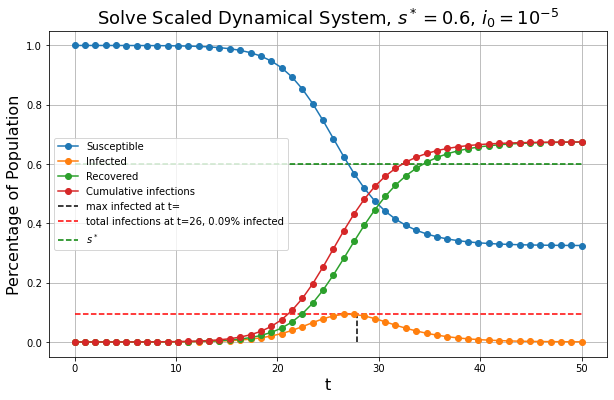

In [29]:

s_star = 0.6
i0 = 1.e-5
t_span = (0., 50)  # can we index it here so that it is more smooth?
u0 = [1.-i0,i0,0]
f = lambda t, u, : F(t, u, s_star,)

sol = solve_ivp(f, t_span, u0, dense_output=True)

total_infections = sol.y[1]+ sol.y[2]
t = numpy.linspace(0, 50)
z = sol.sol(t)
total_infections = z[1]+ z[2]
#don't forget to include the constantly increasing number total infected  

fig = plt.figure(figsize = (10, 6))
axes = fig.add_subplot(1, 1, 1) 

axes.plot(t, z[0], 'o-', label= "Susceptible")
axes.plot(t, z[1], 'o-', label= "Infected")
axes.plot(t, z[2], 'o-', label = "Recovered")
axes.plot(t, total_infections, 'o-', label = "Cumulative infections")

axes.vlines(sol.t[7], 0, max(z[1]), linestyle = 'dashed', label= 'max infected at t=', color = 'k') 
axes.hlines(max(z[1]),0, 50, linestyle = 'dashed', label = 'total infections at t=26, 0.09% infected', color = 'r')
axes.hlines(s_star, 0, 50, linestyle = 'dashed', label = '$s^*$', color = 'g')

axes.set_title("Solve Scaled Dynamical System, $s^* = 0.6$, $i_0 = 10^{-5}$", fontsize = 18) 
axes.set_xlabel("t", fontsize = 16) 
axes.set_ylabel("Percentage of Population", fontsize= 16) 
axes.legend() 
axes.grid() 



**(g)** [8] Write your own code to solve the same system using any constant step-size method we discussed in class that is higher than 2nd order (you can use or modify any of the example codes from the notes and make sure it works for vector valued functions.   Your code should be able to use your function $F$ defined above. Make sure to choose a method that will work for the non-linear right-hand-side. We will test it against the output from solve_ivp with N steps uniform steps in $t\in[0,50]$.  What is the minimum number of steps does your routine take to pass the tests with a relative error of $10^{-4}$ and absolute error of $10^{-5}?.  You can control the number of steps taken with the `N=??` defined at the end of the cell.  **Extra Credit** determine the convergence rate of your method.

In [66]:
def my_ode_solver(f, t_span, u0, N):
    """ implement constant step size ODE integrator using a ________ method
    
    parameters
    ----------
        f: calleable
            vector valued function with interface f(t,u) where u is the state vector
        t_span: float list or array (or tuple)
            array holding range of times to integrate over t_span = [ t_min, t_max]
        u0:  numpy array
            array of initial conditions
        N: integer
            number of time steps to take 
            
    returns:
    --------
        t: numpy array
            array of timesteps from t_min to t_max of length N
        u: numpy array of shape (len(u0), len(t))
            solution array,  the solution at timestep i should be u[:,i]
    """
    
    t = numpy.linspace(t_span[0], t_span[1], N) 
    delta_t = t[1] - t[0]
    u = numpy.empty((N, len(u0))) # creating an N by 3 so that uknot fits into our u[0]
    u[0] = u0

    for (n, t_n) in enumerate(t[:-1]):
        K_1 = delta_t * f(t_n, u[n])
        K_2 = delta_t *f(t_n + delta_t/2., u[n] + K_1/2.)
        K_3 = delta_t * f(t_n +delta_t/2., u[n] + K_2/2.)
        K_4 = delta_t * f(t_n + delta_t, u[n] +K_3)
        u[n+1] = u[n] + 1./6. * (K_1+ 2.*(K_2 +K_3)+K_4)
    u = u.transpose()  # transposing to become the desired 3 by N 
    
    
    return t, u 

# you can control the number of steps used here
N = 100 


In [67]:
print("Need at least 82 steps to reach the tolerance.")

Need at least 82 steps to reach the tolerance.


In [68]:
s_star = 0.6
f = lambda t, u: F(t, u, s_star)

t_span = [0., 50.]
i_0 = 1.e-5
u_0 = numpy.array([1. - i_0, i_0, 0.0])


t, u = my_ode_solver(f, t_span, u_0, N)

# There was a hidden line here implementing sol = solve_ivp to get the "True" solution
sol = solve_ivp(f, t_span, u_0, method='RK45', dense_output=True, rtol=1.e-6, atol = 1.e-8)

numpy.testing.assert_allclose(u, sol.sol(t), rtol=1.e-4, atol=1.e-5)
print('success!')

success!


**(h)** [2] Reproduce your figure from the scipy version (without events)

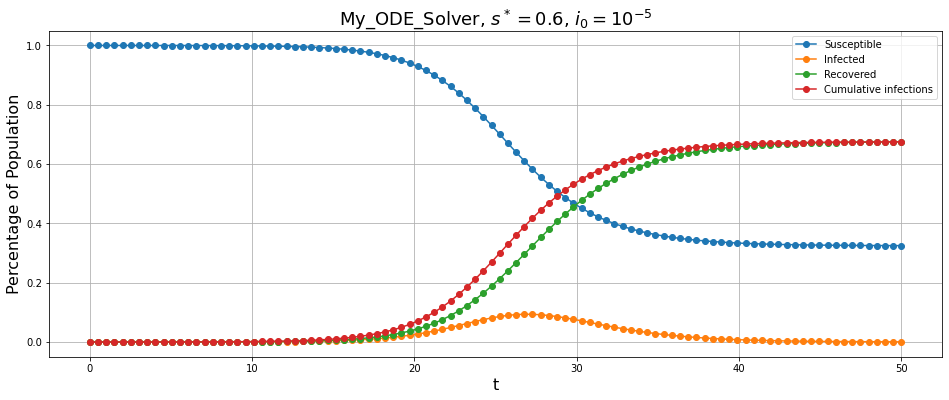

In [72]:
s_star = 0.6 
f = lambda t, u: F(t, u, s_star) 

t_span = [0., 50.]
i_0= 1.e-5
u_0 = numpy.array([1. -i_0, i_0, 0.0])

t, z = my_ode_solver(f, t_span, u_0, N)

fig = plt.figure(figsize = (16, 6))
axes = fig.add_subplot(1, 1, 1) 

axes.plot(t, z[0], 'o-', label= "Susceptible")
axes.plot(t, z[1], 'o-', label= "Infected")
axes.plot(t, z[2], 'o-', label = "Recovered")
axes.plot(t, z[1] + z[2], 'o-', label = "Cumulative infections")

axes.set_title("My_ODE_Solver, $s^* = 0.6$, $i_0 = 10^{-5}$", fontsize = 18) 
axes.set_xlabel("t", fontsize = 16) 
axes.set_ylabel("Percentage of Population", fontsize= 16) 
axes.legend() 
axes.grid() 


###  Themes and Variations -- Some project ideas

The classical Kermack and McKendric model is only one of a vast set of models used to model the spread of infection disease but assumes homogeneous mixing across the entire population.  In addition there are lots of things  to explore with even the simplest SIR model.   If you are interested in this sort of ODE model as a possible project, here are a few things you might want to explore


* Choose a fixed value of $N$ for the maximum susceptible population. Assume that maximum hospital capacity is achieved when the number of infected patients reaches $i_{max}$.  Construct a root-finding problem to find the value of $s^*$ required to keep  the peak number of infected cases $i_{peak} <= i_{max}$. 

* Consider the possibility of re-infection (ugh!).  One model of this assumes that recovered patients can become susceptible again at some rate $\lambda$.  Modify the original SIR model to include this possibility and construct a new scaled set of equations.  This will now be a 2 parameter dynamical system ($s^*$ and another parameter say $\lambda^*$.  Explore the behavior of this new problem.

* Develop a model that includes the effects of vaccinations

* Show that the original SIR model allows at most one peak in infections.  Then try to construct a better model that allows multiple peaks.

* Read [Siettos and Russo, (2013)](https://doi.org/10.4161/viru.24041) (or find a better paper) which reviews a range of epidemiology models including Stochastic SIR models. Wikipedia also has several pages on modeling epidemics ([here](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) , and [here](https://en.wikipedia.org/wiki/Mathematical_modelling_of_infectious_disease)) Pick another model, implement it and compare it's behavior with the basic SIR model.

* Something Numerical: Write an adaptive time stepper built around any two single-step multi-stage schemes and compare your solution to solve_ivp.

* Your own best ideas!



## Question 2 - Absolute Stability Regions Single-Step Multi-stage schemes

**(a)** [4 pt] Taylor Series method:
    
Show that $R(z)$ for a Taylor's series method of order $p$ acting on the model problem $u'=\lambda u$ always just returns the first $p+1$ terms of the Taylor series of $e^z$.

We have the Taylor series $e^z = 1 + z + \frac{z^2}{2!} + \frac{z^3}{3!} + ... + \frac{z^n}{n!}$. We also have that $U(\Delta t) = R(z) U_0$, where $U$ is the discrete approximation. Then..
$$U(\Delta t) = e^{\lambda \Delta t} U_0 = \left [ 1 + \lambda \Delta t + \frac{\lambda \Delta t^2}{2!} + \frac{\lambda \Delta t^3}{3!} + ... + \frac{\lambda \Delta t^n}{n!} \right ] U_0$$
Since $z = \lambda \Delta t$:
$$R(z) = 1 + z + \frac{z^2}{2!} + \frac{z^3}{3!} + ... + \frac{z^n}{n!}$$
This shows that with an order of n, $R(z)$ return n + 1 terms (because for any order Taylor series, there is always one more term than the order since it starts with 1).

**(b)** [4 pt] Plot the regions of absolute stability for Taylor Series methods of order 2-5

You can use the plotting codes given in class and included in the file stability_diagrams.py which are imported in the first cell

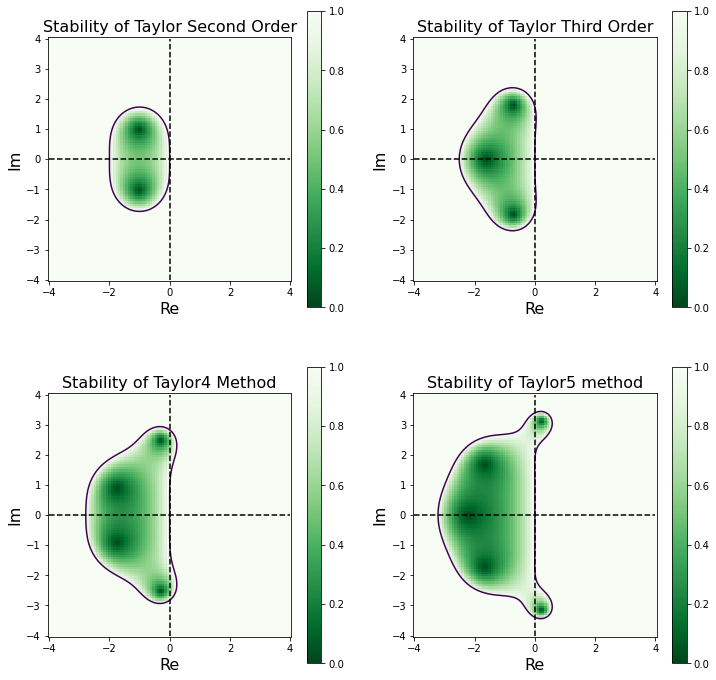

In [31]:
def stability_plot(X, Y, C, axes, title=None, continuous=True):
    """
    Utility function to make stability diagram given complex stability scalar C
    
    parameters:
    -----------
    
    X, Y:  numpy.meshgrids for complex plane
    C: numpy array
        Field to plot,  either |R(z)| for a single step scheme, or max(|xi_i(z)|) for a LMM scheme
    axes: matplotlib axes object
        subplot or plot to draw in. 
    title: string
        subplot title if not None 
    continuous: boolean
        if True, plot a continous coloring of C
        if False, plot Heaviside(C)
    """
    if  continuous:
        Ch = C
    else:
        Ch = numpy.heaviside(C-1,0.)
    pcolor_plot = axes.pcolor(X, Y, Ch, vmin=0, vmax=1, cmap=plt.get_cmap('Greens_r'), shading='auto')
    axes.contour(X, Y, C, 'k', levels=[1.0])
    fig = plt.gcf()
    fig.colorbar(pcolor_plot)
    axes.plot(x, numpy.zeros(x.shape),'k--')
    axes.plot(numpy.zeros(y.shape), y,'k--')
    
    axes.set_xlabel('Re', fontsize=16)
    axes.set_ylabel('Im', fontsize=16)
    if title is not None:
        axes.set_title(title, fontsize=16)
    
    axes.set_aspect('equal')    
    
def plot_stability_ssms(R, x, y, axes=None, title=None, continuous=True):
    """ 
    plot stability regions for single-step multi-stage ODE schemes given the function R(z)
    such that U_{n+1} = R(z)U_n   and z is complex
    
    parameters:
    -----------
    
    R: calleable
        function of a complex variable z such that if |R|<=1, the scheme is absolutely stable
    x: numpy array
        array of values for the real axis
    y: numpy array
        values to plot for the imaginary axis
    axes: matplotlib axes object
        subplot or plot to draw in.  If axes=None create a new figure
    title: string
        subplot title if 
    continuous: boolean
        if True, plot a continous coloring of C
        if False, plot Heaviside(C)
    """
    
    X,Y = numpy.meshgrid(x,y)
    Z = X + 1j * Y
    if axes is None:
        fig = plt.figure(figsize=(8,6))
        axes = fig.add_subplot(1,1,1)
    
    abs_R = numpy.abs(R(Z))
    stability_plot(X, Y, abs_R, axes, title, continuous)
    
def plot_stability_lmm(pi_coeff, x, y, axes=None, title=None, continuous=True):
    """ 
    plot stability regions for linear multi-step  ODE schemes given the coefficients of the stability polynomial
    pi(xi, z)
    
    parameters:
    -----------
    
    pi_coeff: calleable (function of z)
        function that returns array of stability polynomial pi(z)
    x: numpy array
        array of values for the real axis
    y: numpy array
        values to plot for the imaginary axis
    axes: matplotlib axes object
        subplot or plot to draw in.  If axes=None create a new figure
    title: string
        subplot title if not None   
    continuous: boolean
        if True, plot a continous coloring of C
        if False, plot Heaviside(C)
    """
       
    X,Y = numpy.meshgrid(x,y)
    Z = X + 1j * Y
    if axes is None:
        fig = plt.figure(figsize=(8,6))
        axes = fig.add_subplot(1,1,1)
    
    norm_max = numpy.empty(Z.shape)
    for i,row in enumerate(Z):
        for j, z in enumerate(row):
            norm_max[i,j] = max(numpy.abs(numpy.roots(pi_coeff(z))))
    
    stability_plot(X, Y, norm_max, axes, title, continuous)
    
x = numpy.linspace(-4,4,100)
y = numpy.linspace(-4,4,100)

R_Taylor2 = lambda z: 1 + z + (z**2)/2.
R_Taylor3 = lambda z: 1 + z + (z**2)/2. + z**3/6.
R_Taylor4 = lambda z: 1 + z + z**2/2 + z**3/6. + z**4/24.
R_Taylor5 = lambda z: 1 + z + z**2/2 + z**3/6. + z**4/24. + z**5/120

continuous=True

fig = plt.figure(figsize=(12,12))
axes = fig.add_subplot(2,2,1)
plot_stability_ssms(R_Taylor2, x, y, axes=axes, title='Stability of Taylor Second Order', continuous=continuous)

axes = fig.add_subplot(2,2,2)
plot_stability_ssms(R_Taylor3, x, y, axes=axes, title='Stability of Taylor Third Order', continuous=continuous)

axes = fig.add_subplot(2,2,3)
plot_stability_ssms(R_Taylor4, x, y, axes=axes, title='Stability of Taylor4 Method', continuous=continuous)

axes = fig.add_subplot(2,2,4)
plot_stability_ssms(R_Taylor5, x, y, axes=axes, title='Stability of Taylor5 method', continuous=continuous)


**(b)** [4 pt] Derive $R(z)$ for the RK2 method and show that it is equivalent to Taylor 2

**Extra Credit**  show that $R(Z)$ for RK4 is identical to Taylor-4 (in general this is true for explicit RK methods)

$$ U_{n+1} = U_n + \Delta t f(U_n + \frac{1}{2} \Delta t f (U_n)) \Rightarrow$$

$$ U_{n+1} = U_n + \Delta t \lambda (U_n + \frac{1}{2} \Delta t \lambda (U_n)) \Rightarrow$$

Since $z = \lambda\Delta t$

$$ U_{n+1} = U_n + z (U_n + \frac{1}{2} z (U_n)) \Rightarrow$$

$$ U_{n+1} = U_n + U_n z + \frac{1}{2} (U_n)  z^2 \Rightarrow$$

$$ R(z) = 1 + z + \frac{z^2}{2}$$

Taylor 2 is equal to $1 + z + \frac{z^2}{2}$ so the RK2 method is equivalent to Taylor 2.


## Question 3: Linear Multi-Step Schemes - Derivation and stability

[4] Derive the Adams-Moulton 2-step method 
$$
    U_{n+2} = U_{n+1} + \frac{\Delta t}{12} (-f_{n} + 8 f_{n+1} + 5 f_{n+2}),
$$

and its error estimate using the formula for the truncation error of general multi-step schemes
$$
\begin{aligned}
    T(t, u; \Delta t) &= \frac{1}{\Delta t}\left( \sum^r_{j=0} \alpha_j\right) u(t_n) + \left(\sum^r_{j=0} (j\alpha_j - \beta_j)\right) u'(t_n) + \Delta t \left(\sum^r_{j=0} \left (\frac{1}{2}j^2 \alpha_j - j \beta_j \right) \right) u''(t_n) \\
& \quad \quad + \cdots + \Delta t^{q - 1} \left (\sum^r_{j=0} \left(\frac{1}{q!} j^q \alpha_j - \frac{1}{(q-1)!} j^{q-1} \beta_j \right) \right) u^{(q)}(t_n) + \cdots
\end{aligned}$$

i.e. find $\alpha_j$s and $\beta_j$s that zero out terms of the truncation error out to some order.
Some Hint's 
* This is an Adams scheme with three levels so we already know the $\alpha$'s
* Therefore you only have to find the three $\beta$'s $\beta_0$, $\beta_1$ and $\beta_2$
* Use the above formula to find 3 equations for the 3 values of $\beta$
* The remainder term will be the order of the Truncation error

At q = 1, our truncation error is $$T(t, u; \Delta t) = \frac{1}{\Delta t}\left( \sum^r_{j=0} \alpha_j\right) u(t_n) + \left(\sum^r_{j=0} (j\alpha_j - \beta_j)\right) u^\prime(t_n)$$

Since this is an Adams scheme, our $\alpha$'s are $\alpha = 0, \alpha_1 = -1$, and $\alpha_2 = 1$ thus $$\sum^2_{j=0} \alpha_j = 0.$$

Now we have $$\sum^2_{j=0} \frac{1}{q!} j^{q} \alpha_j - \frac{1}{(q-1)!} j^{q-1} \beta_j = 0.$$

For q = 1, we have $$\sum^2_{j=0} j \alpha_j - \beta_j = \beta_0 - 1 - \beta_1 + 2 - \beta_2 = -\beta_0 - \beta_1 - \beta_2 + 1 = 0$$

For q = 2, we have $$\sum^2_{j=0} \frac{1}{2} j^2 \alpha_j - j \beta_j = -\frac{1}{2} - \beta_1 + 2 -2 \beta_2 = -\beta_1 - 2 \beta_2 + \frac{3}{2} = 0$$

For q = 3, we have $$\sum^2_{j=0} \frac{1}{6} j^3 \alpha_j - \frac{1}{2}j^2 \beta_j = -\frac{1}{6} - \frac{1}{2} \beta_1 +\frac{4}{3} - 2 \beta_2 = -\frac{1}{2} \beta_1 -2\beta_2 + \frac{7}{6} = 0$$

We get the following system of equations: 
$$
\begin{aligned}
-\beta_0 - \beta_1 - \beta_2 + 1 = 0 \\
-\beta_1 - 2 \beta_2 + \frac{3}{2} = 0\\
-\frac{1}{2} \beta_1 -2\beta_2 + \frac{7}{6} = 0 \\
\end{aligned}
$$

Thus, 
$$
\begin{aligned}
\beta_0 = -\frac{1}{12} \\
\beta_1 = \frac{2}{3} \\
\beta_2 = \frac{5}{12} \\
\end{aligned}
$$

**(c)** [8] Stability polynomials and Diagrams

Calculate the stability polynomial and plot the stability regions for
1. 2-step Adams-Moulton methods.
1. 3-step Adams-Bashforth methods

which are both 3rd-order methods.  Comment on the relative size of stability regions of these two methods and Taylor-3.

stability polynomial = $\pi(\xi,z)$

2-step Adams-Moulton methods: $$U_{n+2} = U_{n+1} + \frac{\Delta t}{12} (-f(U_n) + 8f(U_{n+1}) + 5f(U_{n+2})) $$

$$U_{n+2} = U_{n+1} + \frac{- \Delta t f(U_n)}{12} + \frac{2 \Delta t f(U_{n+1})}{3} + \frac{5 \Delta t f(U_{n+2})}{12}$$

$$U_{n+2} - U_{n+1} + \frac{\Delta t \lambda(U_n)}{12} - \frac{2 \Delta t \lambda(U_{n+1})}{3} - \frac{5 \Delta t \lambda(U_{n+2})}{12} = 0$$

$$U_{n+2}(1 - \frac{5 \Delta t \lambda}{12}) - U_{n+1}(1 + \frac{2 \Delta t \lambda}{3}) + U_n\frac{\Delta t \lambda}{12} = 0$$

Since $z = \lambda\Delta t$ and $U_n=\xi^n$,

$$\pi(\xi,z) = \xi^2(1 - \frac{5 z}{12}) - \xi(1 + \frac{2 z}{3}) + \frac{z}{12}$$ which has roots when $$(1 - \frac{5 z}{12}) \xi^2 - (1 + \frac{2 z}{3}) \xi + \frac{z}{12} = 0$$

3-step Adams-Bashforth methods: $$U_{n+3} = U_{n+2} + \frac{\Delta t}{12} (5 f(U_n) - 16 f(U_{n+1}) + 23 f(U_{n+2}))$$

$$U_{n+3} = U_{n+2} + \frac{5 \Delta t f(U_n)}{12} - \frac{4 \Delta t f(U_{n+1})}{3} + \frac{23 \Delta t f(U_{n+2})}{12}$$

$$U_{n+3} - U_{n+2} - \frac{5 \Delta t \lambda(U_n)}{12} + \frac{4 \Delta t \lambda (U_{n+1})}{3} - \frac{23 \Delta t \lambda(U_{n+2})}{12}$$

$$U_{n+3} - U_{n+2}(1 + \frac{23 \Delta t \lambda}{12}) + U_{n+1}\frac{4 \Delta t \lambda}{3} - U_n \frac{5 \Delta t \lambda}{12} = 0$$

$$\pi(\xi,z) = \xi^3 - \xi^2(1 + \frac{23 z}{12}) + \xi \frac{4 z}{3} - \frac{5 z}{12}$$ which has roots when $$\xi^3 - (1 + \frac{23 z}{12})\xi^2 + \frac{4 z}{3} \xi - \frac{5 z}{12} = 0$$

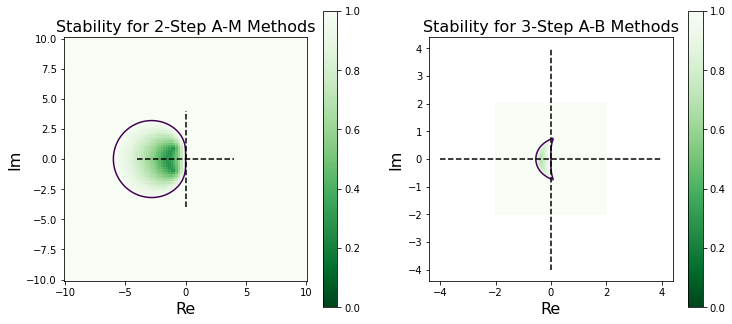

In [35]:
x1 = numpy.linspace(-10, 10, 100)
y1 = numpy.linspace(-10, 10, 100)
x2 = numpy.linspace(-2, 2, 100) 
y2 = numpy.linspace(-2, 2, 100) 
AM = lambda z: numpy.array([1 - 5*z/12, -1 -2*z/3, z/12])
AB = lambda z: numpy.array([1, -(1+23*z/12), 4*z/3, -5*z/12])
continuous = True

fig = plt.figure(figsize = (12,12))
axes = fig.add_subplot(2,2,1)
plot_stability_lmm(AM, x1, y1, axes=axes, title= "Stability for 2-Step A-M Methods", continuous = continuous) 

axes = fig.add_subplot(2,2,2)
plot_stability_lmm(AB, x2, y2, axes=axes, title = "Stability for 3-Step A-B Methods", continuous= continuous) 


The 2 step AM has a larger size of stability. This makes sense when we think about that AM works for more cases than AB as AB is just for zero state while AM works implicitly for much more. 

**(d)**  [6] In class we demonstrated that the Leap-frog method seemed to be unstable, at least for the examples we showed.  Use your tools for stability analysis of Linear Multi-step methods to analyze the general stability of the Leap Frog method and plot its stability diagram. In particular, comment on the case we showed in class for $\lambda$ real and negative.

As you can see below, there is no good range. This is never stable and that is why in class we showed it was unstable regardless of the $\lambda$ values being real, negative, etc. This follows what we saw in class where it lacks stability. 
$$U_{n+2} = U_n + 2 \Delta t f(t_{n+1}, U_{n+1})$$

Since $z = \lambda\Delta t$, we get $$ -U_{n+2} + U_n + 2 z U_{n+1} = 0$$

And since $U_n=\xi^n$, we get $$ \pi(\xi,z) = \xi^2 - 2z\xi - 1$$

<ipython-input-31-2934ec085f66>:24: UserWarning: No contour levels were found within the data range.
  axes.contour(X, Y, C, 'k', levels=[1.0])


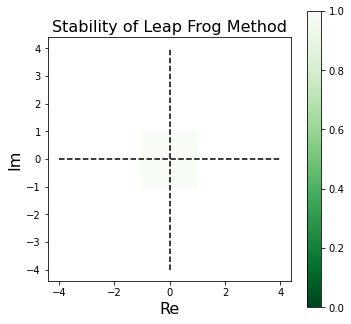

In [39]:
x1 = numpy.linspace(-1, 1, 100)
y1 = numpy.linspace(-1, 1, 100) 

LF = lambda z: numpy.array([1, -2*z, -1])
continuous = True 

fig = plt.figure(figsize = (12,12))
axes = fig.add_subplot(2, 2, 1)
plot_stability_lmm(LF, x1, y1, axes = axes, title = "Stability of Leap Frog Method", continuous = continuous)

    



SyntaxError: invalid syntax (<ipython-input-64-d17674eb7707>, line 1)